# PCA of EEG Features (Dortmund Dataset)
This notebook describes the process of applying PCA to EEG-derived features, exploring dimensionality reduction, and preparing data for clustering.

- Objective: Reduce high-dimensional EEG features to a lower-dimensional space to explore participant variability.
- Dataset: Dortmund dataset (608 participants, multiple EEG features).
- Goals:
  1. Understand structure of the features.
  2. Perform PCA for dimensionality reduction.
  3. Explore variance explained by principal components.
  4. Prepare data for clustering and visualization.

## Load Data
Load the Dortmund dataset and inspect the first few rows.

In [1]:
import pandas as pd
import numpy as np

dort = pd.read_csv("./dataset/Dortmund_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_dort = pd.read_csv("./dataset/Dortmund_age&sex.csv", index_col=0)
# Extract age and sex
age_dort = age_sex_dort['age'].values
sex_dort = age_sex_dort['sex'].values

lemon = pd.read_csv("./dataset/Lemon_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_lemon = pd.read_csv("./dataset/Lemon_age&sex.csv", index_col=0)
# Extract age and sex
age_lemon = age_sex_lemon['age_group'].values # note ages are ranges in Lemon
sex_lemon = age_sex_lemon['sex'].values

## 1. Exploratory Data Analysis
- Preview first few rows and numeric columns.
- Check for missing values.
- Examine feature distributions.

In [2]:
# Print dataset shapes
print(f"Dortmund_features.csv shape: {dort.shape}")
print(f"LEMON_features.csv shape: {lemon.shape}\n")

dort_cols = set(dort.columns)
lemon_cols = set(lemon.columns)

print("Features only in Dortmund:")
print(dort_cols - lemon_cols, "\n")

print("Features only in LEMON:")
print(lemon_cols - dort_cols, "\n")


Dortmund_features.csv shape: (600, 147)
LEMON_features.csv shape: (190, 147)

Features only in Dortmund:
set() 

Features only in LEMON:
set() 



All features are shared in Dortmund and Lemon

1. Scatter Plot of First Two Raw Features


Plotting the first two numeric features:
Feature 1: nl_rqa mean diag length
Feature 2: kurtosis_amp_theta



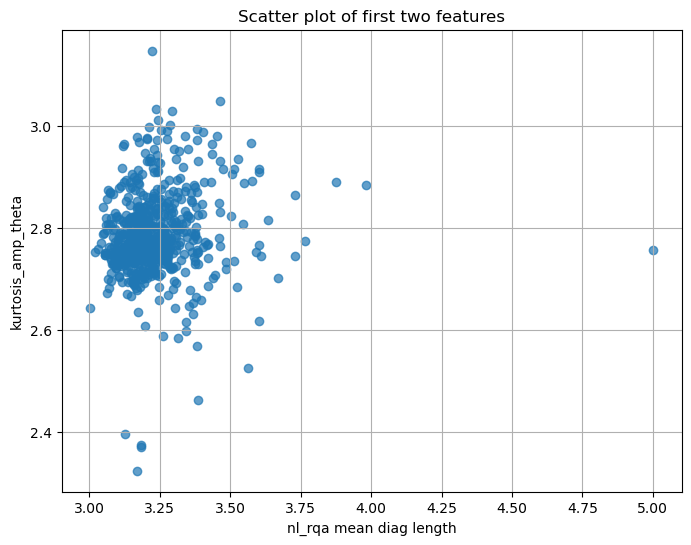

In [3]:
import matplotlib.pyplot as plt

# Select only numeric columns (exclude IDs or non-numeric)
numeric_data = dort.select_dtypes(include=['float64', 'int64'])
dort_numeric = numeric_data.values

# Define features (all numeric columns)
features = dort_numeric  # shape: (participants, features)

# Print what we are plotting
print("Plotting the first two numeric features:")
print(f"Feature 1: {numeric_data.columns[0]}")
print(f"Feature 2: {numeric_data.columns[1]}\n")

# Scatter plot of first two features
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7)
plt.xlabel(numeric_data.columns[0])
plt.ylabel(numeric_data.columns[1])
plt.title("Scatter plot of first two features")
plt.grid(True)
plt.show()


2. Feature-Age/Sex Relationship
-   **Age** — plotted using scatter plots  
-   **Sex** — plotted using boxplots (female vs male)

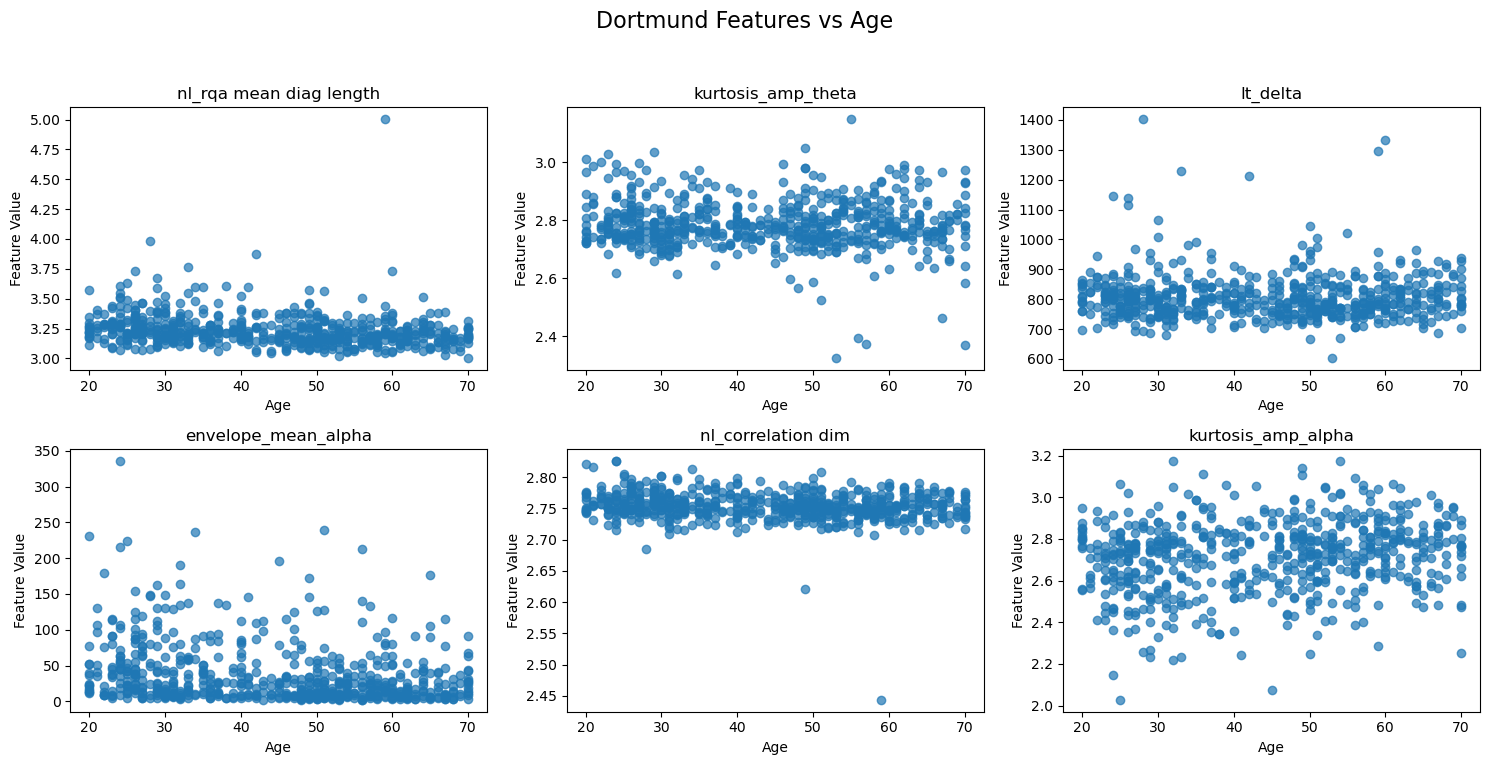

/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_61210/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_61210/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_61210/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dor

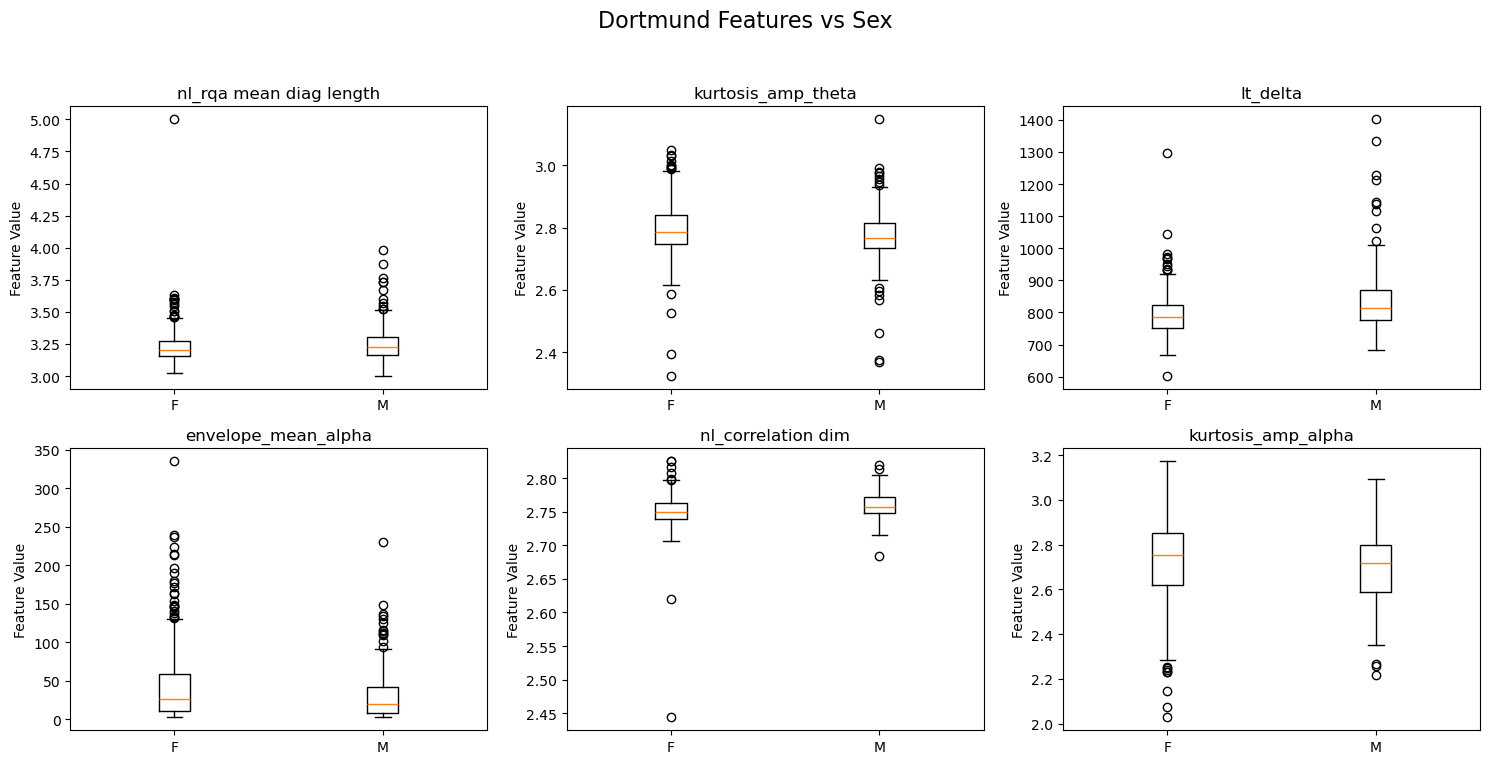

In [4]:
# Numeric Dortmund features
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
num_features_to_plot = 6

# -------------------------
# Plot features vs Age
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].scatter(age_dort, dort_numeric.iloc[:, i], alpha=0.7)
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Age", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------
# Plot features vs Sex
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
                    labels=['F','M'])
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Sex", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Principal Component Analysis (PCA)
- Reduce dimensionality to an optimal number of PCs for clustering while optionally visualizing in 2D.
- Examine explained variance, singular values, and component loadings to understand feature contributions.


1. Standardize Features
- PCA is sensitive to scale, so all numeric features are standardized to mean = 0 and variance = 1 before PCA.

2. Optimal PCA Computation
- Compute full PCA and determine the minimum number of PCs needed to reach a threshold variance (default 80%).
- Plot cumulative explained variance and scree plot to visualize the variance captured by each component.

3.  PCA Component Loadings & Transformed Data
- Loadings indicate how strongly each original feature contributes to each principal component.
- Transformed PCA data (scores) are used for clustering.
- Optionally export loadings and PCA-transformed dataset for further analysis.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def run_optimal_pca(data, threshold=0.8, dataset_name="Dataset", export=False):
    """
    Standardizes data, computes full PCA, finds optimal PCs using cumulative variance,
    plots PCA results, and returns PCA-transformed data and components.
    
    Parameters:
        data : pandas DataFrame (numeric)
        threshold : float, e.g. 0.8 for 80% variance
        dataset_name : str (used in plot titles)
        
    Returns:
        pca_optimal_components : np.array (PCA-transformed data)
        pca_model_optimal : PCA object fitted with optimal n_components
        num_pcs_threshold : int (optimal number of PCs)
        explained_variance_full : np.array (all PCs variance)
        components_optimal : np.array (loadings)
    """

    # 1. Standardize
    scaled = StandardScaler().fit_transform(data)

    # 2. Full PCA
    pca_full = PCA()
    pca_full.fit(scaled)

    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative = np.cumsum(explained_variance_full)

    # 3. Determine optimal PCs
    num_pcs_threshold = np.argmax(cumulative >= threshold) + 1

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cumulative plot
    axes[0].plot(range(1, len(cumulative)+1), cumulative*100, marker='o')
    axes[0].axvline(num_pcs_threshold, color='r', linestyle='--',
                    label=f'{int(threshold*100)}% at PC{num_pcs_threshold}')
    axes[0].set_title(f"{dataset_name}: Cumulative Explained Variance")
    axes[0].set_xlabel("Number of Principal Components")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].legend()
    axes[0].grid(True)

    # Scree plot
    axes[1].plot(range(1, len(explained_variance_full)+1),
                 explained_variance_full*100, marker='o', alpha=0.7)
    axes[1].axhline(explained_variance_full[num_pcs_threshold-1]*100,
                    color='r', linestyle='--',
                    label=f'PC{num_pcs_threshold} variance')
    axes[1].set_title(f"{dataset_name}: Scree Plot")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4. Run optimal PCA
    pca_optimal = PCA(n_components=num_pcs_threshold)
    transformed = pca_optimal.fit_transform(scaled)

    # --- Printing ---
    print(f"\n=== {dataset_name}: Optimal PCA Summary ===")
    print(f"Optimal number of PCs for {int(threshold*100)}% variance: {num_pcs_threshold}")
    print(f"Variance explained by PC1: {explained_variance_full[0]*100:.2f}%")
    print(f"Total variance explained by {num_pcs_threshold} PCs: {cumulative[num_pcs_threshold-1]*100:.2f}%\n")

    print("\n=== Explained Variance of Optimal PCs ===")
    for i, v in enumerate(pca_optimal.explained_variance_ratio_, start=1):
        print(f"PC{i}: {v*100:.2f}%")

    print("\n=== First 5 Singular Values ===")
    print(pca_optimal.singular_values_[:5])

    print("\n=== PCA Loadings (First 3 Features Per PC) ===")
    for i, pc in enumerate(pca_optimal.components_, start=1):
        print(f"PC{i}: {pc[:3]}")


    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    if export:
        # --- PCA Components (Loadings) ---
        # Rows = PCs, Columns = original features
        # This shows HOW MUCH each original feature contributes to each PC
        loadings_df = pd.DataFrame(
            pca_optimal.components_,
            columns=data.columns,
            index=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        loadings_path = f"dataset/{dataset_name}_pca_loadings.csv"
        loadings_df.to_csv(loadings_path, index=True)

        # --- PCA Transformed Data ---
        # Rows = Subjects, Columns = PCs
        # This is what you use for CLUSTERING
        transformed_df = pd.DataFrame(
            transformed,
            index=data.index, # Keep original subject IDs!
            columns=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        transformed_path = f"dataset/{dataset_name}_pca.csv"
        transformed_df.to_csv(transformed_path, index=True)

        print(f"\n✓ Exported loadings to:     {loadings_path}")
        print(f"✓ Exported PCA scores to:   {transformed_path}")
        print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")

    return transformed, pca_optimal, num_pcs_threshold, explained_variance_full, pca_optimal.components_


OPTIMAL PCA (DORTMUND DATASET):

data_pca      → The PCA-transformed dataset (participants × optimal PCs).
                These are the coordinates of each subject in PCA space.

data_model    → The fitted PCA model object.
                Contains components_, explained_variance_ratio_, singular_values_, etc.

data_nPC      → The optimal number of principal components selected automatically.
                Determined by reaching the cumulative variance threshold (e.g., 80%).

data_var      → Explained variance ratio of each selected PC.
                Tells you how much variance each principal component captures.

data_loadings → PCA loadings (components): contribution of each original feature to each PC.
                Shape = (nPC × n_features). Used for interpretation and clustering.

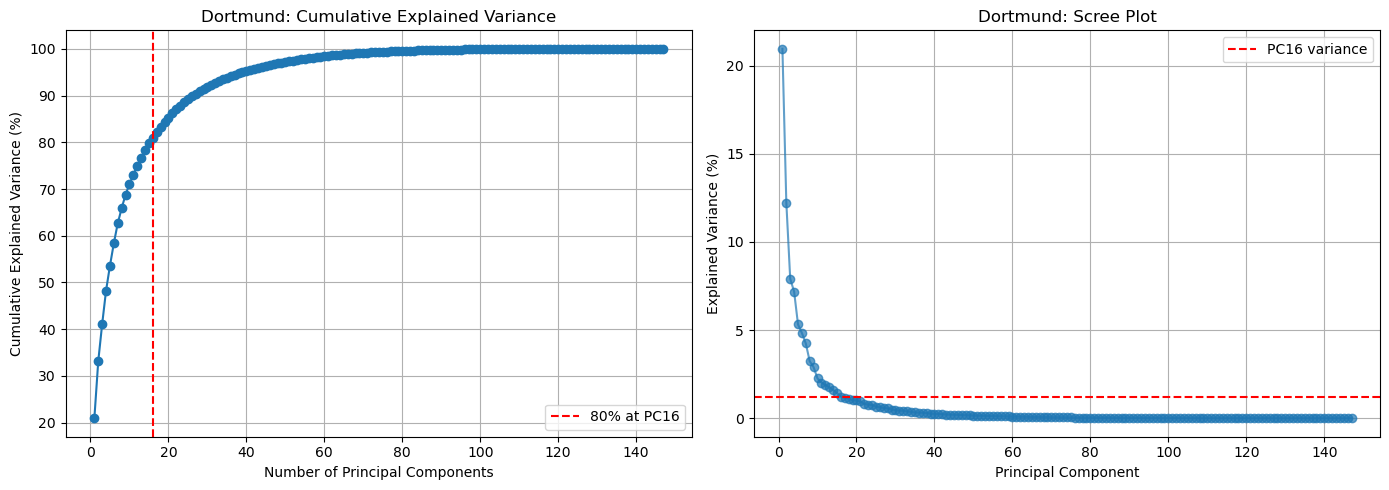


=== Dortmund: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 16
Variance explained by PC1: 20.95%
Total variance explained by 16 PCs: 80.96%


=== Explained Variance of Optimal PCs ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.22%

=== First 5 Singular Values ===
[135.92426733 103.85380041  83.50298095  79.57932546  68.48214739]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [ 0.07755219  0.03162877 -0.02748839]
PC2: [-0.17531187 -0.01302005 -0.12494591]
PC3: [-0.0580306  -0.06893838 -0.1305785 ]
PC4: [-0.01288422  0.02623794 -0.09575217]
PC5: [ 0.06350165 -0.12897606 -0.02706489]
PC6: [0.03376758 0.01408434 0.08135534]
PC7: [0.08086687 0.08481029 0.04429653]
PC8: [-0.07386086  0.09189502 -0.09996016]
PC9: [0.00613684 0.06776912 0.07689234]
PC10: [-0.02051697 -0.11689849 -0.03653251]
PC11: [0.00513602 0.23600781 0.10385513]
P

In [6]:
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
dort_pca, dort_model, dort_nPC, dort_var, dort_loadings = run_optimal_pca(
    dort_numeric,
    threshold=0.80,
    dataset_name="Dortmund",
    export=True
)

OPTIMAL PCA (LEMON DATASET):

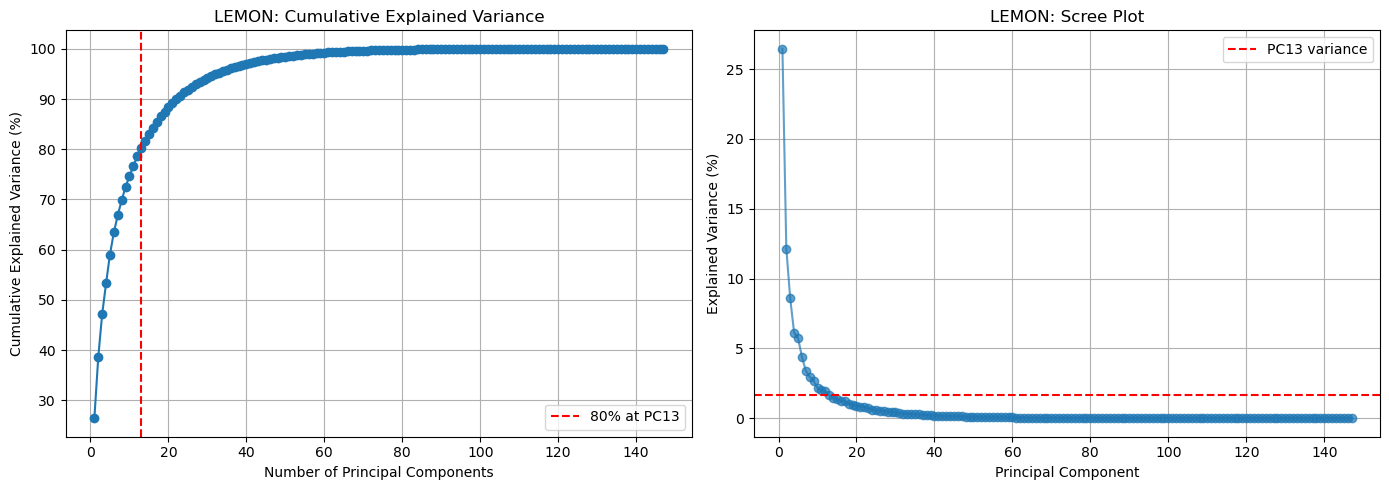


=== LEMON: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 13
Variance explained by PC1: 26.45%
Total variance explained by 13 PCs: 80.24%


=== Explained Variance of Optimal PCs ===
PC1: 26.45%
PC2: 12.15%
PC3: 8.57%
PC4: 6.13%
PC5: 5.75%
PC6: 4.41%
PC7: 3.40%
PC8: 2.96%
PC9: 2.68%
PC10: 2.15%
PC11: 2.01%
PC12: 1.93%
PC13: 1.64%

=== First 5 Singular Values ===
[85.9498367  58.24597055 48.9346571  41.37887684 40.0681235 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [0.1183683  0.00626448 0.06426968]
PC2: [-0.01681211  0.05213916 -0.10845719]
PC3: [ 0.04190047 -0.01404165  0.09092072]
PC4: [-0.00944458  0.11810503  0.12506928]
PC5: [0.15848921 0.02815616 0.03572152]
PC6: [-0.0697668  -0.02414548 -0.02613632]
PC7: [ 0.03277971  0.0790457  -0.14885173]
PC8: [-0.02086367 -0.14332598  0.05058819]
PC9: [ 0.00972326  0.17819356 -0.03012205]
PC10: [ 0.07506859 -0.07097608  0.02327065]
PC11: [-0.00868137 -0.18580685 -0.04964539]
PC12: [ 0.00321458 -0.22565086  0.10436

In [7]:
lemon_numeric = lemon.select_dtypes(include=['float64', 'int64'])
lemon_pca, lemon_model, lemon_nPC, lemon_var, lemon_loadings = run_optimal_pca(
    lemon_numeric,
    threshold=0.8,
    dataset_name="LEMON",
    export=True
)


## 3. PCA Stability Analysis: Bootstrap 
To assess the stability of PCA-derived feature subspaces for two datasets (Dortmund and Lemon) - understand how robust the principal components are to sampling variability

1. **Bootstrap Resampling:**  
 - For each dataset, we create `n_boot` resampled datasets by sampling subjects with replacement.
- PCA is applied to each resampled dataset, keeping components that explain 99% of the variance.

2. **Subspace Comparison:**  
- For each pair of bootstrap PCA results within the same dataset, we compute the singular values of the matrix product between their component matrices.
- Singular values close to 1 = nearly identical subspaces (high stability)
- Also compute singular values between Dortmund and Lemon bootstraps to see how similar the feature subspaces are across datasets.

In [8]:
from numpy.linalg import svd
from sklearn.utils import resample

def bootstrap_pca(X, n_boot, variance_threshold=0.99):
    """
    Compute PCA on multiple bootstrap resamples of the dataset to assess stability.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The data matrix to analyze.
    - n_boot: int
        Number of bootstrap resamples.
    - variance_threshold: float
        Fraction of variance to retain in PCA.
    
    Returns:
    - components_boot: list of arrays
        Each array contains PCA components for one bootstrap sample (shape: n_features x n_components).
    - min_n_comp: int
        Minimum number of components across all bootstrap samples.
    """

    n_samples, n_features = X.shape
    components_boot = []
    min_n_comp = n_features

    for i in range(n_boot):
        # Resample rows (participants) with replacement
        X_resampled = resample(X, random_state=i)

        # Standardize resampled data
        X_scaled = StandardScaler().fit_transform(X_resampled)

        # Fit PCA to bootstrap-sampled data
        pca = PCA(n_components=variance_threshold)
        pca.fit(X_scaled)

        # Store the component vectors
        components_boot.append(pca.components_.T)   # shape: features × components
        
        # Keep track of minimum number of components across bootstraps
        min_n_comp = np.min((min_n_comp, len(pca.components_)))

    return components_boot, min_n_comp



def singular_values(mat1, mat2):
    """
    Measure similarity between two PCA component matrices using singular values.
    
    Parameters:
    - mat1, mat2: arrays of shape (n_features, n_components)
    
    Returns:
    - Array of singular values representing alignment of subspaces.
    """

    M = mat1.T @ mat2
    _, s, _ = svd(M)
    return s

In [9]:
# Number of bootstrap iterations
n_boot = 50  # For readability in examples; typically use >=100 in actual analysis

# Run bootstrap PCA on Dortmund and LEMON datasets
dort_comp, min_dort = bootstrap_pca(dort, n_boot)
lem_comp, min_lem = bootstrap_pca(lemon, n_boot)

# Find the minimum number of components across all bootstraps/datasets
min_n_comp = np.min((min_dort, min_lem))

# Trim each bootstrap PCA result to have the same number of components to allow to compare subspaces using singular values
dort_comp = [boot[:, :min_n_comp] for boot in dort_comp]
lem_comp = [boot[:, :min_n_comp] for boot in lem_comp]
# have aligned PCA bases of shape (features, min_n_com

In [10]:
# Initialize dictionary to store singular values
results = {
    "within_Dortmund": {},
    "within_Lemon": {},
    "between_DL": {}
}

# Compute singular values within bootstraps:
# within Dortmund
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(dort_comp):
        if j > i: # only upper-triangle comparisons to avoid duplicates
            results["within_Dortmund"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# within Lemon
for i, boot1 in enumerate(lem_comp):
    for j, boot2 in enumerate(lem_comp):
        if j > i:
            results["within_Lemon"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# cross dataset
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(lem_comp):
        if j >= i: # compare each Dortmund bootstrap to corresponding or later LEMON bootstraps
            results["between_DL"][f"boots {i}-{j}"] = singular_values(boot1, boot2)


### Results

##### Within-Dataset Stability (Lemon-Lemon or Dortmund): 
All within-Lemon bootstrap similarity distributions fall extremely close to **1.0**, with most values in the range **0.98–1.00**.  
This indicates:
- *High cluster stability:* each component is internally consistent.
- *Robust centroid estimation:* resampling does not meaningfully shift the cluster centers.
- *Well-separated structure:* there is no sign of component collapse or merging.

In short, the Lemon dataset exhibits **very strong internal reproducibility**.

In [11]:
# Display results
# - High singular values (~1) indicate strong alignment of PCA subspaces
# - Lower singular values indicate differences between subspaces

results["within_Dortmund"]

{'boots 0-1': array([0.9999279 , 0.99988393, 0.99987109, 0.99982064, 0.99977573,
        0.9997746 , 0.99971882, 0.999648  , 0.99955679, 0.99946051,
        0.99943515, 0.99941993, 0.99923949, 0.99915257, 0.99894795,
        0.9987893 , 0.99851433, 0.99836351, 0.99819188, 0.99796168,
        0.99773731, 0.99731435, 0.99690501, 0.99681464, 0.99556334,
        0.99501453, 0.99450552, 0.99308858, 0.99244819, 0.99202955,
        0.98956804, 0.98795887, 0.98636515, 0.98411225, 0.98120508,
        0.97757083, 0.97637197, 0.96417358, 0.95638782, 0.94664979,
        0.94320432, 0.94060078, 0.8893207 , 0.85488407, 0.71868349,
        0.54265819, 0.3378146 , 0.07661985]),
 'boots 0-2': array([0.99995529, 0.99990218, 0.99987723, 0.99984876, 0.99980266,
        0.99972686, 0.99967026, 0.99962332, 0.99953921, 0.99944788,
        0.99936265, 0.99927589, 0.99922969, 0.99908244, 0.99892295,
        0.99883394, 0.99858684, 0.99836935, 0.99783827, 0.99766579,
        0.99749123, 0.99726425, 0.99674158, 

In [12]:
results["within_Lemon"]

{'boots 0-1': array([0.99990938, 0.99986571, 0.99983518, 0.99978748, 0.99977174,
        0.99972117, 0.99962076, 0.99950479, 0.99941294, 0.99924589,
        0.99918958, 0.999013  , 0.99879189, 0.99868807, 0.99827684,
        0.99794825, 0.99785856, 0.99713904, 0.99672698, 0.99660903,
        0.99632104, 0.99370978, 0.99280904, 0.99247252, 0.99101403,
        0.98903547, 0.9884913 , 0.98747312, 0.98476097, 0.98225324,
        0.98042741, 0.97714543, 0.97414918, 0.96587961, 0.9604031 ,
        0.94924614, 0.92340516, 0.91058309, 0.90089117, 0.89236109,
        0.85127871, 0.83775769, 0.71239564, 0.49052181, 0.42431931,
        0.31869748, 0.19763483, 0.11852567]),
 'boots 0-2': array([0.99993249, 0.99991124, 0.99988645, 0.99981565, 0.99976618,
        0.99970235, 0.99958774, 0.99957618, 0.99946196, 0.99943588,
        0.99917839, 0.99905519, 0.9988536 , 0.99861681, 0.9985457 ,
        0.99835493, 0.99805122, 0.9977645 , 0.99747716, 0.99689084,
        0.99650143, 0.99585004, 0.99536209, 

##### Cross-Dataset Similarity (Dortmund vs. Lemon)
Cross-dataset bootstrap similarities fall in the range:
- **~0.20–0.27** at the high end  
- rapidly dropping toward **0.01–0.0001**

This pattern indicates:

1. **Minimal structural alignment between the datasets.**
   The components extracted from Dortmund do not resemble those from Lemon.

2. **No evidence of shared component geometry.**
   If the datasets had corresponding factors or clusters, we would expect cross-dataset similarities closer to **0.6–0.9**.  
   Instead, values are an order of magnitude lower.

3. **Clear separability.**
   The between-dataset similarity distributions never overlap with the within-dataset distributions (0.98–1.00 vs. 0.00–0.27).  
   This is strong evidence that the datasets express **distinct underlying patterns**.

In [13]:
results["between_DL"]

{'boots 0-0': array([0.9255668 , 0.89696747, 0.89003154, 0.8653877 , 0.86066908,
        0.84429678, 0.82272728, 0.80194326, 0.78618633, 0.77321261,
        0.75282506, 0.7440331 , 0.71281016, 0.70695044, 0.68228261,
        0.67917073, 0.66674916, 0.64040274, 0.62367468, 0.605064  ,
        0.59319875, 0.56927802, 0.55662307, 0.51813363, 0.51432097,
        0.46937674, 0.44702088, 0.42507299, 0.40144722, 0.36630302,
        0.33322242, 0.32391925, 0.31426679, 0.27016452, 0.26361247,
        0.23650224, 0.22696438, 0.18217666, 0.16751737, 0.15215428,
        0.12111007, 0.10678401, 0.09069664, 0.07456828, 0.06509955,
        0.03148886, 0.00886152, 0.00264476]),
 'boots 0-1': array([0.9124043 , 0.8888228 , 0.87673721, 0.86082757, 0.85279827,
        0.8501011 , 0.82015384, 0.81178908, 0.78981487, 0.77615261,
        0.75118124, 0.734793  , 0.72017265, 0.71172062, 0.68013827,
        0.67138019, 0.65738172, 0.64109523, 0.62252838, 0.60380991,
        0.58160497, 0.57863408, 0.55632655, 

### Visualising Bootstraping

Within Dortmund PCA - Mean singular values per component:
[0.99992981 0.99989645 0.99986247 0.99982353 0.99977971 0.99973104
 0.9996742  0.9996077  0.99953209 0.9994452  0.99934408 0.99923118
 0.99909874 0.99894667 0.99877702 0.99857859 0.99834462 0.99808115
 0.99778332 0.99743294 0.99704488 0.99658928 0.99606456 0.99545999
 0.99475615 0.99397325 0.99304638 0.991944   0.99067076 0.98919735
 0.98746548 0.98538837 0.982912   0.97990214 0.97626705 0.97179138
 0.9663296  0.95908601 0.95056063 0.93916851 0.9239022  0.9030323
 0.87350616 0.83148978 0.76687194 0.65886396 0.47285226 0.17472859]

Within LEMON PCA - Mean singular values per component:
[0.99992923 0.99989469 0.99985707 0.99981394 0.99976296 0.999705
 0.99963848 0.99955814 0.9994656  0.99936024 0.99923597 0.99908937
 0.99891684 0.99872395 0.99848759 0.99820663 0.99788123 0.9974978
 0.99704967 0.99652695 0.99590678 0.99517821 0.99434008 0.99331883
 0.99211617 0.99073671 0.98905586 0.98703838 0.98471575 0.98191335
 0.97852427 0.9744

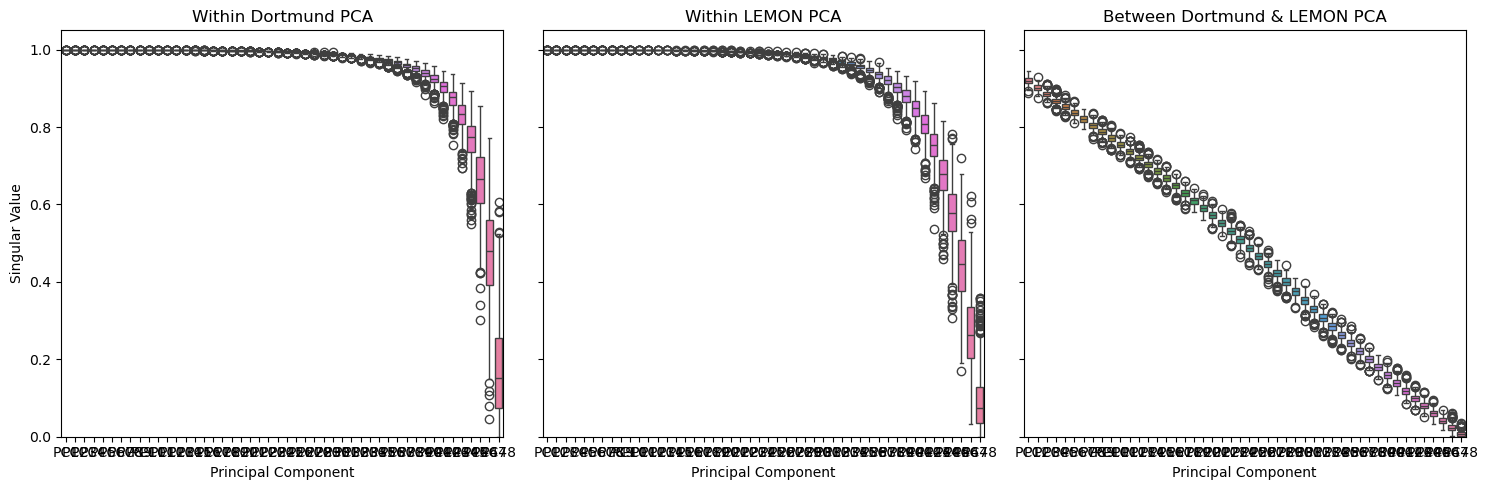

In [14]:
import seaborn as sns

def summarize_bootstrap_results_subplots(results_dicts, titles):
    """
    Plot multiple bootstrap singular value boxplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        sns.boxplot(data=all_svals, ax=ax)

        n_components = all_svals.shape[1]
        ax.set_xticks(range(n_components))
        ax.set_xticklabels([f"PC{i}" for i in range(1, n_components+1)])

        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

        # Print mean singular values
        mean_svals = np.mean(all_svals, axis=0)
        print(f"{title} - Mean singular values per component:\n{mean_svals}\n")

    axes[0].set_ylabel("Singular Value")
    plt.tight_layout()
    plt.show()

# Call the function
summarize_bootstrap_results_subplots(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


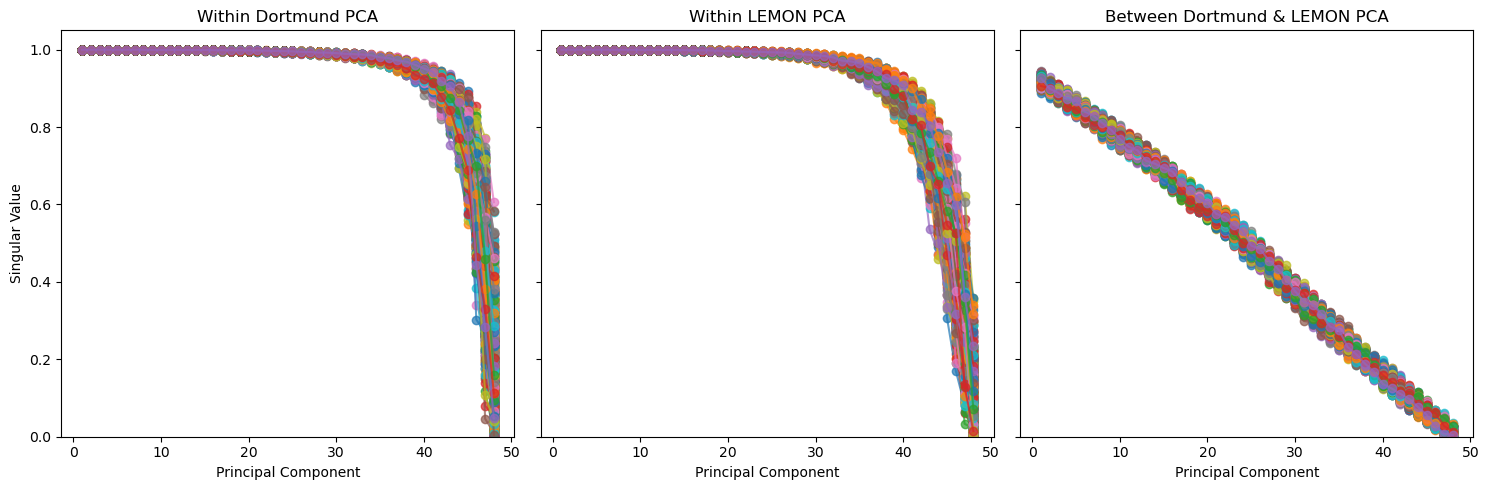

In [15]:
def lineplot_bootstrap_subplot(results_dicts, titles):
    """
    Plot multiple bootstrap singular value lineplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        for svals in all_svals:
            ax.plot(range(1, len(svals)+1), svals, marker='o', alpha=0.7)
        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

    axes[0].set_ylabel("Singular Value")  # Only left-most plot needs y-axis label
    plt.tight_layout()
    plt.show()

# Call the function with your results
lineplot_bootstrap_subplot(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


In [16]:
def summary_table_all(results_dicts, labels):
    
    for results_dict, label in zip(results_dicts, labels):
        all_svals = np.array(list(results_dict.values()))
        mean_svals = np.mean(all_svals, axis=0)
        std_svals = np.std(all_svals, axis=0)
        df = pd.DataFrame({
            "Component": range(1, len(mean_svals)+1),
            "Mean Singular Value": mean_svals,
            "Std Dev": std_svals
        })
        print(f"\nSummary for {label}:\n")
        display(df)

summary_table_all(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund", "Within LEMON", "Between Dortmund & LEMON"]
)



Summary for Within Dortmund:



,Component,Mean Singular Value,Std Dev
0,1,0.999930,0.000020
1,2,0.999896,0.000026
2,3,0.999862,0.000033
3,4,0.999824,0.000041
4,5,0.999780,0.000050
5,6,0.999731,0.000058
6,7,0.999674,0.000069
7,8,0.999608,0.000080
8,9,0.999532,0.000094
9,10,0.999445,0.000111



Summary for Within LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.999929,0.000020
1,2,0.999895,0.000026
2,3,0.999857,0.000033
3,4,0.999814,0.000042
4,5,0.999763,0.000053
5,6,0.999705,0.000062
6,7,0.999638,0.000075
7,8,0.999558,0.000091
8,9,0.999466,0.000105
9,10,0.999360,0.000123



Summary for Between Dortmund & LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.920335,0.008929
1,2,0.902124,0.008041
2,3,0.886116,0.008308
3,4,0.868797,0.008135
4,5,0.852894,0.008486
5,6,0.837422,0.009314
6,7,0.821068,0.009225
7,8,0.804843,0.009620
8,9,0.788306,0.009759
9,10,0.771715,0.009794


### PCA Stability and Cross-Dataset Comparison (Summary)

- **Within Dortmund:** Principal components are highly stable across bootstrap samples (singular values ≈ 0.98–0.999). PCA subspace is robust and reproducible.
- **Within LEMON:** Components are stable overall, though the least dominant components vary slightly more (singular values ≈ 0.64–0.99).
- **Between Dortmund and LEMON:** Singular values are very low (≈ 0.0001–0.25), indicating that PCA subspaces are dataset-specific and not shared.

### Conclusion:
- PCA is reliable within each dataset but differs between datasets.
- The same PCA cannot be used for both Dortmund and LEMON, so downstream analyses (e.g., clustering) should be performed on PCA fitted separately to each dataset.

### Next Steps (Optional)
If desired, the bootstrap distributions can be further summarized by:

- KL-divergence between distributions  
- p-values for separability  
- violin/ridge plots for publication  
- cluster dendrograms based on similarity